# Can we use the Federal Prime Lending Rate to predict Mutual Fund Performance?

In [305]:
import yfinance as yf
import pandas as pd
import requests
import pickle
from bs4 import BeautifulSoup
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts

import warnings


%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Yahoo Finance Data on the XLV Fund

In [288]:
xlv = yf.Ticker('XLV')
xlv_hist = xlv.history(period = 'max', actions = False)
xlv_hist['Change'] = xlv_hist['Close'] - xlv_hist['Open']
xlv_hist['Volume'] = xlv_hist.Volume.astype('float64')
xlv_hist.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-12-22,18.41,18.60,18.41,18.58,5700.0,0.17
1998-12-23,18.69,18.99,18.69,18.99,18100.0,0.30
1998-12-24,19.02,19.11,18.94,19.11,4900.0,0.09
1998-12-28,19.05,19.11,18.83,18.83,15500.0,-0.22
1998-12-29,18.83,19.25,18.83,19.25,5300.0,0.42


In [289]:
xlv_hist = xlv_hist.iloc[::-1]
xlv_hist_monthly = xlv_hist['Close'].resample('MS')
xlv_monthly_mean = xlv_hist_monthly.mean()
xlv_monthly_mean.isnull().sum()

0

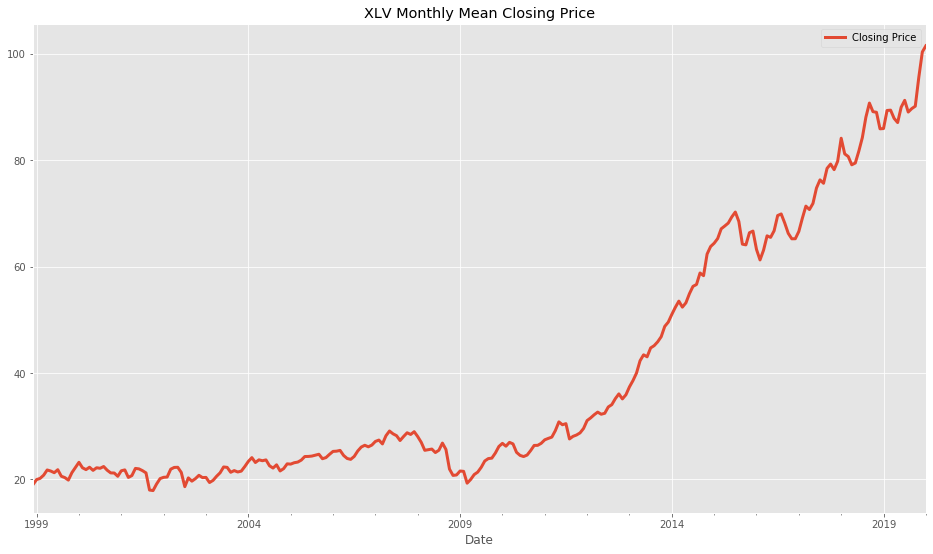

In [290]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (16,9))
xlv_monthly_mean.plot(linewidth = 3, label = 'Closing Price')
plt.title('XLV Monthly Mean Closing Price')
plt.legend()
plt.show()

#There is an upwards Trend

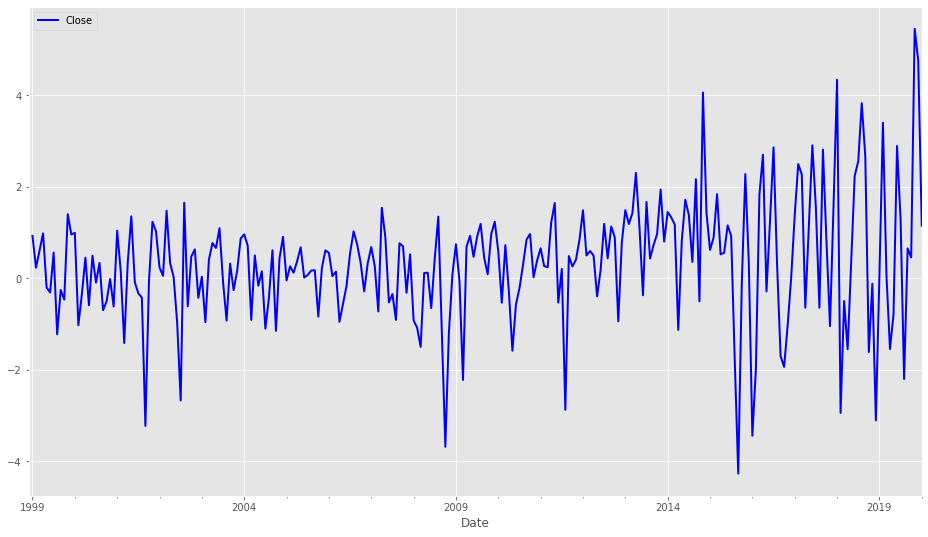

In [291]:
#Take 1st order difference of XLV
xlv_monthly_diff = xlv_monthly_mean.diff(periods = 1)
fig = plt.figure(figsize = (16, 9))
xlv_monthly_diff.plot(linewidth = 2, c = 'b')
plt.legend()
plt.show()

## Perform a Seasonal Decomposition to check for trends, seasonality, and residual distribution

In [292]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(xlv_monthly_mean))

In [303]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

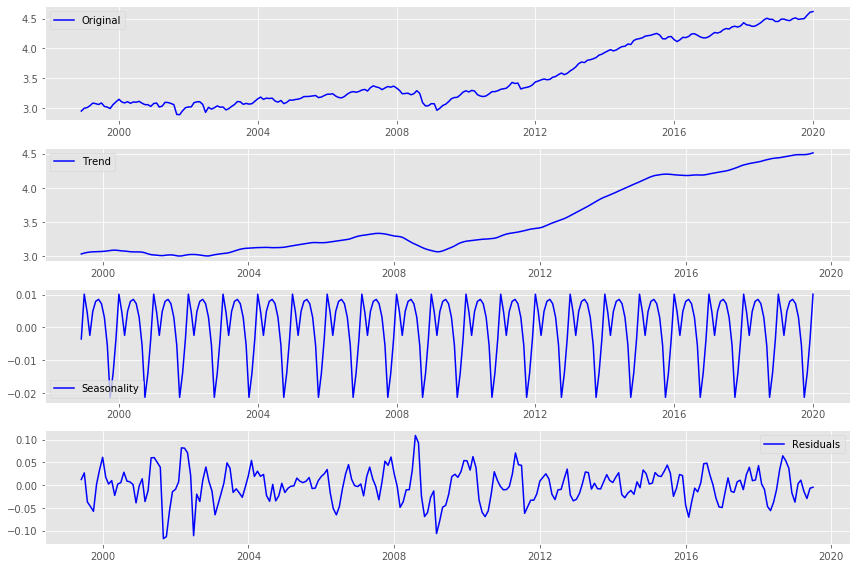

In [307]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(xlv_monthly_mean), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [309]:
#drop NaN
xlv_log_decompose = residual
xlv_log_decompose.dropna(inplace = True)

In [314]:
#check stationarity
def stationarity_check(TS):
    
    from statsmodels.tsa.stattools import adfuller
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    
    dftest = adfuller(TS)
    
    fig = plt.figure(figsize = (16,9))
    orig = plt.plot(TS, color = 'b', label = 'original')
    mean = plt.plot(rolmean, color = 'r', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    print('Results of Dickey-Fuller Test')
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
    return None

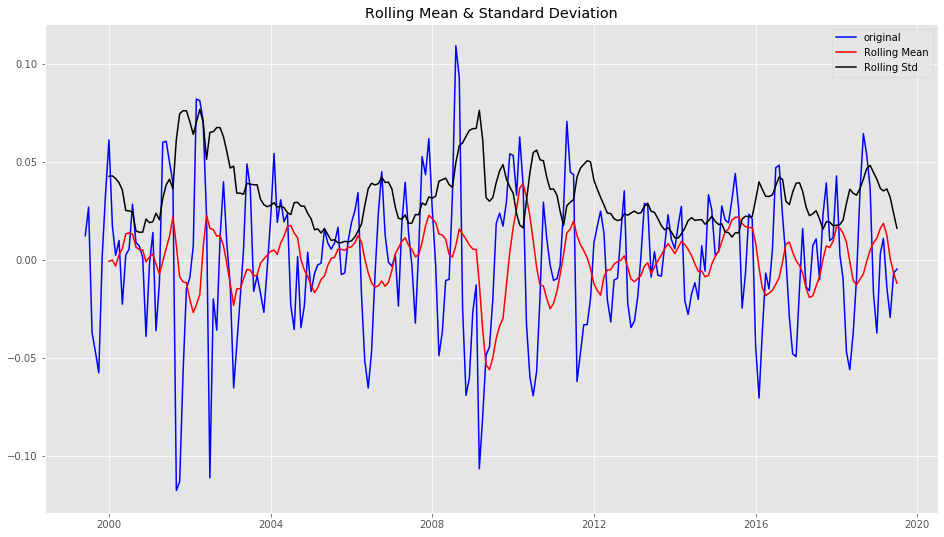

Results of Dickey-Fuller Test
Test Statistic                -7.406343e+00
p-value                        7.327849e-11
#Lags Used                     1.000000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


In [315]:
stationarity_check(xlv_log_decompose)

#### P-val = 7.32e-11 -->  Reject the null hypothesis that the data is not stationary

## Run Arima Model